# Выбор региона для добычи нефти

Допустим, мы работаем в нефтяной компании. Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Оглавление:
* [1. Загрузка и подготовка данных](#1)
* [2. Обучение и проверка модели](#2)
* [3. Подготовка к расчёту прибыли](#3)
* [4. Расчёт прибыли и рисков](#4)

# 1. Загрузка и подготовка данных <a class="anchor" id="1"></a>

Импортируем библиотеки:

In [1]:
# <импорт библиотеки pandas>
import pandas as pd

# <импорт библиотеки math>
import math

# <импорт библиотеки sklearn>
import sklearn

# <Отключение предупреждений>
import warnings
warnings.filterwarnings('ignore')

# <импорт библиотеки numpy>
import numpy as np

# <импорт библиотеки seaborn для построения графиков>
import seaborn as sns

# <импорт библиотеки matplotlib для построения графиков>
import matplotlib.pyplot as plt

Прочитаем файлы с данными:

In [2]:
# <чтение файла с данными с сохранением в переменную df_region_0>
df_region_0 = pd.read_csv('/datasets/geo_data_0.csv')

# <чтение файла с данными с сохранением в переменную df_region_1>
df_region_1 = pd.read_csv('/datasets/geo_data_1.csv')

# <чтение файла с данными с сохранением в переменную df_region_2>
df_region_2 = pd.read_csv('/datasets/geo_data_2.csv')

Рассмотрим информацию по датафреймам и первые 5 строк:

In [3]:
# <рассмотрим датафрейм df_region_0>
print(df_region_0.info())
df_region_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# <рассмотрим датафрейм df_region_1>
print(df_region_1.info())
df_region_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
# <рассмотрим датафрейм df_region_2>
print(df_region_2.info())
df_region_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Подробнее опишем значение каждого атрибута.

Каждая таблица - это регион, где происходит добыча нефти:

* *id* — уникальный идентификатор месторождения;
* *f0*, *f1*, *f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
* *product* — объём запасов в месторождении (тыс. баррелей).

В целом очевидно что признаки масштабированы и пропусков нет. Типы данных менять не нужно. Сбросим столбец *id*, так как для обучения моделей он нам не понадобится.

In [6]:
# <создадим новые датафреймы, в них будут данные которые необходимы для обучения модели.>
df_region_0_preprocessed = df_region_0.drop('id', axis=1)
df_region_1_preprocessed = df_region_1.drop('id', axis=1)
df_region_2_preprocessed = df_region_2.drop('id', axis=1)

### Вывод

Данные загружены, заранее были масштабированы, пропусков нет. Мы сбросили столбец, который не пригодится нам для обучения модели. Перейдем к следующему пункту.

# 2. Обучение и проверка модели <a class="anchor" id="2"></a>

Разобьем данные для каждого региона на две выборки: обучающую и валидационную. Разобьем их в отношении 3:1.

In [7]:
# <Импортируем функцию из бибилиотеки sklearn>
from sklearn.model_selection import train_test_split

In [8]:
# <Разделим датафрейм на features и target - целевой признак>
target_0 = df_region_0_preprocessed['product']
features_0 = df_region_0_preprocessed.drop('product', axis=1)

# <Поделим датафрейм на обучающую и валидационную выборку>
features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

In [9]:
# <Разделим датафрейм на features и target - целевой признак>
target_1 = df_region_1_preprocessed['product']
features_1 = df_region_1_preprocessed.drop('product', axis=1)

# <Поделим датафрейм на обучающую и валидационную выборку>
features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

In [10]:
# <Разделим датафрейм на features и target - целевой признак>
target_2 = df_region_2_preprocessed['product']
features_2 = df_region_2_preprocessed.drop('product', axis=1)

# <Поделим датафрейм на обучающую и валидационную выборку>
features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

Обучим модель линейной регресии для первого региона, выведем оценки и средний запас сырья в месторождении.

In [11]:
# <Импортируем метод линейной регрессии>
from sklearn.linear_model import LinearRegression

# <Импортируем коэффициент детерминации>
from sklearn.metrics import r2_score

# <Импортируем среднюю абсолютную ошибку>
from sklearn.metrics import mean_absolute_error

# <Импортируем среднюю квадратичную ошибку>
from sklearn.metrics import mean_squared_error

In [12]:
# <Создадим модель лин. регрессии>
model_lr_0 = LinearRegression().fit(features_0_train, target_0_train)

# <обучаем модель> 
predictions_0 = model_lr_0.predict(features_0_valid)

# <Выводим значения оценок и средний запас сырья в месторождении(фактический)>
print('R2:','{:.4f}'.format(r2_score(target_0_valid,predictions_0)))
print('MAE:','{:.3f}'.format(mean_absolute_error(target_0_valid,predictions_0)))
print('RMSE:','{:.3f}'.format(mean_squared_error(target_0_valid,predictions_0)**0.5))
print('Средний запас сырья:','{:.1f}'.format(target_0.mean()))

R2: 0.2799
MAE: 30.920
RMSE: 37.579
Средний запас сырья: 92.5


Обучим модель линейной регресии для второго региона, выведем оценки и средний запас сырья в месторождении.

In [13]:
# <Создадим модель лин. регрессии>
model_lr_1 = LinearRegression().fit(features_1_train, target_1_train)

# <обучаем модель> 
predictions_1 = model_lr_1.predict(features_1_valid)

# <Выводим значения оценок и средний запас сырья в месторождении(фактический)>
print('R2:','{:.4f}'.format(r2_score(target_1_valid,predictions_1)))
print('MAE:','{:.3f}'.format(mean_absolute_error(target_1_valid,predictions_1)))
print('RMSE:','{:.3f}'.format(mean_squared_error(target_1_valid,predictions_1)**0.5))
print('Средний запас сырья:','{:.1f}'.format(target_1.mean()))

R2: 0.9996
MAE: 0.719
RMSE: 0.893
Средний запас сырья: 68.8


Обучим модель линейной регресии для третьего региона, выведем оценки и средний запас сырья в месторождении.

In [14]:
# <Создадим модель лин. регрессии>
model_lr_2 = LinearRegression().fit(features_2_train, target_2_train)

# <обучаем модель> 
predictions_2 = model_lr_2.predict(features_2_valid)

# <Выводим значения оценок и средний запас сырья в месторождении(фактический)>
print('R2:','{:.4f}'.format(r2_score(target_2_valid,predictions_2)))
print('MAE:','{:.3f}'.format(mean_absolute_error(target_2_valid,predictions_2)))
print('RMSE:','{:.3f}'.format(mean_squared_error(target_2_valid,predictions_2)**0.5))
print('Средний запас сырья:','{:.1f}'.format(target_2.mean()))

R2: 0.2052
MAE: 32.793
RMSE: 40.030
Средний запас сырья: 95.0


Проанализируем результаты, сразу отметим что у второго региона низкие ошибки в модели и почти идеальный коэффициент детерминации. Посмотрим на корреляцию между признаками у показателей в этом регионе.

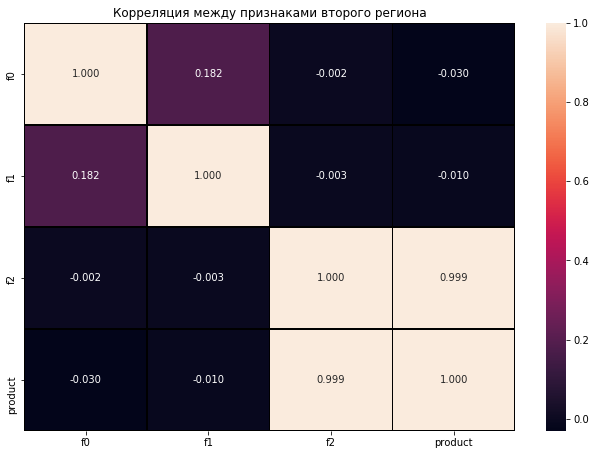

In [15]:
# <построим график, отображающий корреляцию между признаками>
plt.figure(figsize=(11,7.5))
sns.heatmap(df_region_1.loc[:, ['f0','f1','f2','product']].corr(), annot=True, fmt=".3f", linewidths=.5,linecolor='black')
plt.title("Корреляция между признаками второго региона")
plt.show()

На графике видно что между признаком *f2* и целевым признаком *product* почти полная линейная связь.

Проверим тоже самое в 1 и 3 регионе.

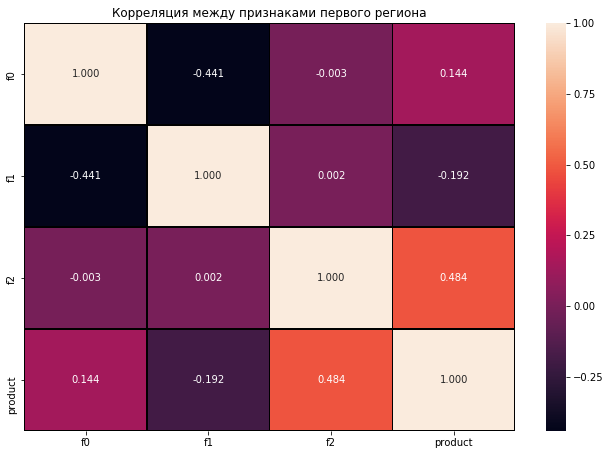

In [16]:
# <построим график, отображающий корреляцию между признаками>
plt.figure(figsize=(11,7.5))
sns.heatmap(df_region_0.loc[:, ['f0','f1','f2','product']].corr(), annot=True, fmt=".3f", linewidths=.5,linecolor='black')
plt.title("Корреляция между признаками первого региона")
plt.show()

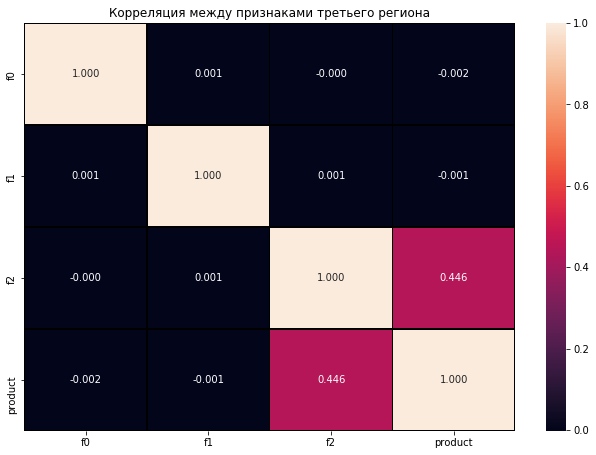

In [17]:
# <построим график, отображающий корреляцию между признаками>
plt.figure(figsize=(11,7.5))
sns.heatmap(df_region_2.loc[:, ['f0','f1','f2','product']].corr(), annot=True, fmt=".3f", linewidths=.5,linecolor='black')
plt.title("Корреляция между признаками третьего региона")
plt.show()

Относительно одинаковые результаты. Что интересно, у первого региона какая-никакая корреляция между всеми признаками и целевым признаком присутствует, и засчет этого модель сработала лучше по сравнению с третьим регионом.

### Вывод

Мы построили модели линейной регресии и предсказали объём сырья в месторождениях трех регионов. Обнаружили занимательную корреляцию во втором регионе, и заметили схожесть в корреляциях первого и третьего региона.

# 3. Подготовка к расчёту прибыли <a class="anchor" id="3"></a>

Сохраним в коде все ключевые значения для расчета прибыли и рисков

In [18]:
# <эти значения были даны нам в условиях задачи>
Barrel = 4500
Budget = 10000000000
Oil_well = 50000000

Подсчитаем минимальный средний объём сырья в месторождениях региона, достаточный для его разработки.

In [19]:
# <подсчитаем минимальное количество баррелей, чтобы выйти в 0 при разработке месторождения.>
minimal_size = Oil_well/Barrel
minimal_size

11111.111111111111

Какой из этого можно сделать вывод? Я решил посчитать сколько таких месторождений в каждом регионе.

In [20]:
# <Уже тут мы преобразуем np.array в pd.Series, но это сделано будет>
# <еще в функции бутстрэпа, на случай если бы этого блока не было.>
predictions_0 = pd.Series(predictions_0)
predictions_0[predictions_0 >= (minimal_size/1000)].count()

24995

In [21]:
predictions_1 = pd.Series(predictions_1)
predictions_1[predictions_1 >= (minimal_size/1000)].count()

20854

In [22]:
predictions_2 = pd.Series(predictions_2)
predictions_2[predictions_2 >= (minimal_size/1000)].count()

25000

Больше всего в первом и третьем. Во втором почти пятая часть месторождений не соответствует этим требованиям.

Напишем функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели.

In [24]:
# <Эта функция будет работать и для другого бюджета, стоимости бурения и стоимости барреля.>
def profit(data,budget,barrel_price,drilling_price):
    
    # <количество месторождений, которые мы можем разработать при имеющемся бюджете>
    field_q = budget/drilling_price
    
    # <отсортируем их по запасам>
    data = data.sort_values(ascending=False)
    
    # <сбросим индексы, чтобы потом взять первые field_q-1 штук>
    data.reset_index(inplace=True, drop = True)
    
    # <тут получаем Series с самыми богатыми месторождениями>
    data = data.loc[0:math.floor(field_q)-1,]
    
    # <возвращаем суммарную прибыль>
    return sum(data*barrel_price*1000)

### Вывод

* Мы сохранили в коде значения, которые используем в своей функции подсчета прибыли.
* Подсчитали минимальный объём месторождения которое имеет смысл разрабатывать для получения прибыли в будущем.
* Написали функцию для подсчета прибыли.

# 4. Расчёт прибыли и рисков <a class="anchor" id="4"></a>

Напишем функцию *Bootstrap* и используем технику *Bootstrap* для подсчета распределения прибыли для каждого региона.

In [25]:
# <Добавим случайности нашей функции, чтобы каждый раз брался разный сэмпл>
from numpy.random import RandomState
state = RandomState(12345)

In [26]:
# <В качестве аргумента функции нужны только значения целевого признака>
def bootstrap(predictions):
    values = []
    predictions = pd.Series(predictions)
    
    for i in range(1000):
        # <отбираем 500 случайных месторождений, повтороения допускаются, это суть бутстрэпа>
        predictions_subsample = predictions.sample(n=500, replace=True, random_state=state)
         # <подсчитываем прибыль и добавляем ее в Series прибылей>
        values.append(profit(predictions_subsample, Budget, Barrel, Oil_well))
    
    # <находим доверительный интервал и риск убытков.>
    values = pd.Series(values)
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    risk = len(values[values<0])/len(values)
    
    # <выводим результат>
    print('Средняя прибыль:','{:.2f}'.format(values.mean()))
    print('Начало доверительного интервала:','{:.2f}'.format(lower))
    print('Конец доверительного интервала:','{:.2f}'.format(upper))
    print('Риск убытков:','{:.2f}'.format(risk))
    
    return values

Подсчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для первого региона:

In [27]:
# <выводим результат>
values = bootstrap(predictions_0)

Средняя прибыль: 103580260542.08
Начало доверительного интервала: 101401373359.81
Конец доверительного интервала: 105988772713.79
Риск убытков: 0.00


Подсчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для второго региона:

In [28]:
# <выводим результат>
bootstrap(predictions_1)

Средняя прибыль: 104591672842.23
Начало доверительного интервала: 100760478225.15
Конец доверительного интервала: 108616321297.54
Риск убытков: 0.00


0      1.031200e+11
1      1.009839e+11
2      1.012126e+11
3      1.050154e+11
4      1.055640e+11
           ...     
995    1.056409e+11
996    1.048215e+11
997    1.021082e+11
998    1.102417e+11
999    1.023267e+11
Length: 1000, dtype: float64

Подсчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для третьего региона:

In [29]:
# <выводим результат>
bootstrap(predictions_2)

Средняя прибыль: 102717422041.22
Начало доверительного интервала: 100911157074.57
Конец доверительного интервала: 104522088825.20
Риск убытков: 0.00


0      1.035881e+11
1      1.030218e+11
2      1.016068e+11
3      1.038539e+11
4      1.018317e+11
           ...     
995    1.024388e+11
996    1.013999e+11
997    1.043602e+11
998    1.017412e+11
999    1.021717e+11
Length: 1000, dtype: float64

Несмотря на то, что во втором регионе меньше месторождений с минимальным объёмом для промышленной разработки, я думаю что для разработки месторождений подходит второй регион, так как:
* Во втором регионе наибольшая средняя прибыль.
* Наибольший конец доверительного интервала.
* Учитывая бюджет на разработку месторождений, 20000 месторождений должно хватит с лихвой. Этот вывод делается на основе условий задачи, исследователю неизвестны скрытые условия задачи =)

### Вывод

Мы подсчитали распределение прибыли для каждого региона, среднюю прибыль, 95%-й доверительный интервал прибыли, и риск убытков. Решили какой регион подходит для разработки месторождений.